In [ ]:
msg = "Hello World"
print(msg)

Hello World


In [ ]:
# configure spark variables
from pyspark.context import SparkContext
from pyspark.sql.context import SQLContext
from pyspark.sql.session import SparkSession
    
sc = SparkContext()
sqlContext = SQLContext(sc)
spark = SparkSession(sc)

# load up other dependencies
import re
import pandas as pd

import glob

raw_data_files = glob.glob('../ansible/.results/bpftrace/server1-1200m-1.out')
raw_data_files

base_df = spark.read.text(raw_data_files)
base_df.printSchema()

base_df.show(10, truncate=False)

root
 |-- value: string (nullable = true)

+-------------------------------------------------------------+
|value                                                        |
+-------------------------------------------------------------+
|Attaching 12 probes...                                       |
|Tracing latency of network stack funtions. Hit Ctrl-C to end.|
|@q1[openssl]: count 137, average 1406, total 192689          |
|@q1[ksoftirqd/169]: count 6, average 2611, total 15668       |
|                                                             |
|@q2[openssl]: count 872, average 6842, total 5966375         |
|@q2[ksoftirqd/169]: count 31, average 903775, total 28017048 |
|                                                             |
|                                                             |
|@q4[ksoftirqd/169]: count 143, average 947, total 135453     |
+-------------------------------------------------------------+
only showing top 10 rows



In [ ]:
sample_logs = [item['value'] for item in base_df.take(15)]
sample_logs

['Attaching 12 probes...',
 'Tracing latency of network stack funtions. Hit Ctrl-C to end.',
 '@q1[openssl]: count 137, average 1406, total 192689',
 '@q1[ksoftirqd/169]: count 6, average 2611, total 15668',
 '',
 '@q2[openssl]: count 872, average 6842, total 5966375',
 '@q2[ksoftirqd/169]: count 31, average 903775, total 28017048',
 '',
 '',
 '@q4[ksoftirqd/169]: count 143, average 947, total 135453',
 '@q4[openssl]: count 9791, average 952, total 9323492',
 '',
 '@q5[openssl]: count 74553, average 434, total 32427855',
 '@q5[ksoftirqd/169]: count 1009, average 446, total 450618',
 '']

In [ ]:
bpftrace_ps_pattern = r'^@(q\d)\[([\d\D]*)\]\D*(\d+)\D*(\d+)\D*(\d+)([\d\D]*)'
ps = [re.search(bpftrace_ps_pattern, item).groups()
           if re.search(bpftrace_ps_pattern, item)
           else None
           for item in sample_logs]
ps

[None,
 None,
 ('q1', 'openssl', '137', '1406', '192689', ''),
 ('q1', 'ksoftirqd/169', '6', '2611', '15668', ''),
 None,
 ('q2', 'openssl', '872', '6842', '5966375', ''),
 ('q2', 'ksoftirqd/169', '31', '903775', '28017048', ''),
 None,
 None,
 ('q4', 'ksoftirqd/169', '143', '947', '135453', ''),
 ('q4', 'openssl', '9791', '952', '9323492', ''),
 None,
 ('q5', 'openssl', '74553', '434', '32427855', ''),
 ('q5', 'ksoftirqd/169', '1009', '446', '450618', ''),
 None]

In [ ]:
bpftrace_cs_pattern = r'^@(uc)\D*(\d+)\D*(\d+)\D*(\d+)([\d\D]*)'
cs = [re.search(bpftrace_cs_pattern, item).groups()
           if re.search(bpftrace_cs_pattern, item)
           else None
           for item in sample_logs]
cs

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [8]:
from pyspark.sql.functions import regexp_extract

bpftrace_cs_df = base_df.select(
                                regexp_extract('value', bpftrace_cs_pattern, 2).alias('cs_count'),
                                regexp_extract('value', bpftrace_cs_pattern, 3).alias('cs_average'),
                                regexp_extract('value', bpftrace_cs_pattern, 4).alias('cs_total'),
).filter(' cs_count != ""')

bpftrace_cs_df.show(15)

+--------+----------+--------+
|cs_count|cs_average|cs_total|
+--------+----------+--------+
|    2041|     32254|65831562|
|    2123|      6093|12935663|
|    2670|      6674|17821187|
|    2142|      6466|13852272|
|    2220|      6520|14475643|
|    2068|      6259|12944316|
|    2441|      6083|14850249|
|    2106|      5994|12624615|
|    2081|      5402|11241927|
|    2175|      6186|13455724|
|    2993|     12533|37513451|
|    2248|     10055|22603743|
|    2168|      7632|16546510|
|    2065|      5878|12138880|
|    2597|      6218|16149213|
+--------+----------+--------+
only showing top 15 rows



In [9]:
print(bpftrace_cs_df.toPandas().to_numpy()[0])

['2041' '32254' '65831562']


In [10]:
from pyspark.sql.functions import regexp_extract

bpftrace_logs_df = base_df.select(
                                regexp_extract('value', bpftrace_ps_pattern, 1).alias('level'),
                                regexp_extract('value', bpftrace_ps_pattern, 2).alias('program'),
                                regexp_extract('value', bpftrace_ps_pattern, 3).alias('pkt_count'),
                                regexp_extract('value', bpftrace_ps_pattern, 4).alias('pkt_average'),
                                regexp_extract('value', bpftrace_ps_pattern, 5).alias('pkt_total')
                                ).filter(' level != "" ')
bpftrace_logs_df.show(15, truncate=True)

+-----+-------------+---------+-----------+---------+
|level|      program|pkt_count|pkt_average|pkt_total|
+-----+-------------+---------+-----------+---------+
|   q1|      openssl|      137|       1406|   192689|
|   q1|ksoftirqd/169|        6|       2611|    15668|
|   q2|      openssl|      872|       6842|  5966375|
|   q2|ksoftirqd/169|       31|     903775| 28017048|
|   q4|ksoftirqd/169|      143|        947|   135453|
|   q4|      openssl|     9791|        952|  9323492|
|   q5|      openssl|    74553|        434| 32427855|
|   q5|ksoftirqd/169|     1009|        446|   450618|
|   q1|      openssl|      425|       1190|   505868|
|   q1|ksoftirqd/169|       13|       1686|    21920|
|   q1|kworker/169:2|        3|       3867|    11602|
|   q2|      openssl|     1702|        611|  1040884|
|   q2|ksoftirqd/169|       48|        754|    36236|
|   q2|kworker/169:2|        3|       3035|     9107|
|   q4|      openssl|    13435|        946| 12711296|
+-----+-------------+-------

In [11]:
from pyspark.sql.functions import regexp_extract

bpftrace_cs_df = base_df.select(
                                regexp_extract('value', bpftrace_cs_pattern, 2).alias('cs_count'),
                                regexp_extract('value', bpftrace_cs_pattern, 3).alias('cs_average'),
                                regexp_extract('value', bpftrace_cs_pattern, 4).alias('cs_total'),
).filter(' cs_count != ""')

bpftrace_cs_df.show(15)

+--------+----------+--------+
|cs_count|cs_average|cs_total|
+--------+----------+--------+
|    2041|     32254|65831562|
|    2123|      6093|12935663|
|    2670|      6674|17821187|
|    2142|      6466|13852272|
|    2220|      6520|14475643|
|    2068|      6259|12944316|
|    2441|      6083|14850249|
|    2106|      5994|12624615|
|    2081|      5402|11241927|
|    2175|      6186|13455724|
|    2993|     12533|37513451|
|    2248|     10055|22603743|
|    2168|      7632|16546510|
|    2065|      5878|12138880|
|    2597|      6218|16149213|
+--------+----------+--------+
only showing top 15 rows



In [12]:
cs_array = bpftrace_cs_df.toPandas().to_numpy()[0]
print(cs_array)

['2041' '32254' '65831562']


In [13]:
from pyspark.sql.functions import lit

bpftrace_res_df = bpftrace_logs_df.withColumn("cs_count", lit(cs_array[0])
                    ).withColumn("cs_average", lit(cs_array[1])
                    ).withColumn("cs_total", lit(cs_array[2]))
bpftrace_res_df.show(15, truncate=True)

+-----+-------------+---------+-----------+---------+--------+----------+--------+
|level|      program|pkt_count|pkt_average|pkt_total|cs_count|cs_average|cs_total|
+-----+-------------+---------+-----------+---------+--------+----------+--------+
|   q1|      openssl|      137|       1406|   192689|    2041|     32254|65831562|
|   q1|ksoftirqd/169|        6|       2611|    15668|    2041|     32254|65831562|
|   q2|      openssl|      872|       6842|  5966375|    2041|     32254|65831562|
|   q2|ksoftirqd/169|       31|     903775| 28017048|    2041|     32254|65831562|
|   q4|ksoftirqd/169|      143|        947|   135453|    2041|     32254|65831562|
|   q4|      openssl|     9791|        952|  9323492|    2041|     32254|65831562|
|   q5|      openssl|    74553|        434| 32427855|    2041|     32254|65831562|
|   q5|ksoftirqd/169|     1009|        446|   450618|    2041|     32254|65831562|
|   q1|      openssl|      425|       1190|   505868|    2041|     32254|65831562|
|   

In [14]:
raw_data_files = glob.glob('../ansible/.results/iperf/server1-1200m-1.out')
raw_data_files

base_df = spark.read.text(raw_data_files)
base_df.printSchema()

base_df.show(10, truncate=False)

root
 |-- value: string (nullable = true)

+---------------------------------------------------------------------------------+
|value                                                                            |
+---------------------------------------------------------------------------------+
|------------------------------------------------------------                     |
|Server listening on UDP port 5001                                                |
|Receiving 1470 byte datagrams                                                    |
|UDP buffer size:  208 KByte (default)                                            |
|------------------------------------------------------------                     |
|[  3] local 10.0.0.2 port 5001 connected with 10.0.0.1 port 39183                |
|[ ID] Interval       Transfer     Bandwidth        Jitter   Lost/Total Datagrams |
|[  3]  0.0-60.0 sec  8.38 GBytes  1.20 Gbits/sec   0.012 ms 2800/6122450 (0.046%)|
+--------------------------------

In [15]:
sample_logs = [item['value'] for item in base_df.take(15)]
sample_logs

iperf_s_pattern = r'[\d\D]*-([\d.]*)\D*([\d.]*)\D*([\d.]*)\D*([\d.]*)\D*([\d/]*)\D*([\d.]*)([\d\D]*)'
cs = [re.search(iperf_s_pattern, item).groups()
           if re.search(iperf_s_pattern, item)
           else None
           for item in sample_logs]
cs

[('', '', '', '', '', '', ''),
 None,
 None,
 None,
 ('', '', '', '', '', '', ''),
 None,
 None,
 ('60.0', '8.38', '1.20', '0.012', '2800/6122450', '0.046', '%)')]

In [16]:
raw_data_files = glob.glob('../ansible/.results/openssl/server1-1200m-1.out')
raw_data_files

base_df = spark.read.text(raw_data_files)
base_df.printSchema()

base_df.show(10, truncate=False)

root
 |-- value: string (nullable = true)

+-----------------------------------------------------------------------------+
|value                                                                        |
+-----------------------------------------------------------------------------+
|Doing aes-256 cbc for 10s on 16 size blocks: 88870772 aes-256 cbc's in 8.34s |
|Doing aes-256 cbc for 10s on 64 size blocks: 21869876 aes-256 cbc's in 7.63s |
|Doing aes-256 cbc for 10s on 256 size blocks: 5490295 aes-256 cbc's in 7.66s |
|Doing aes-256 cbc for 10s on 1024 size blocks: 1379086 aes-256 cbc's in 7.62s|
|Doing aes-256 cbc for 10s on 8192 size blocks: 171294 aes-256 cbc's in 7.59s |
|Doing aes-256 cbc for 10s on 16384 size blocks: 85618 aes-256 cbc's in 7.56s |
+-----------------------------------------------------------------------------+



In [17]:
sample_logs = [item['value'] for item in base_df.take(15)]
sample_logs

openssl_s_pattern = r'\D*([\d]*)\D*([\d]*)\D*([\d]*)\D*([\d]*)\D*([\d]*)\D*([\d.]*)([\d\D]*)'
cs = [re.search(openssl_s_pattern, item).groups()
           if re.search(openssl_s_pattern, item)
           else None
           for item in sample_logs]
cs

openssl_logs_df = base_df.select(
                                regexp_extract('value', openssl_s_pattern, 6).alias('us_time')
                                ).filter(' us_time != "" ')

openssl_logs_df.show(5)
cs_array = openssl_logs_df.toPandas().to_numpy()

us_time = 0.0
for a in cs_array:
    us_time += float(a[0])

us_time

+-------+
|us_time|
+-------+
|   8.34|
|   7.63|
|   7.66|
|   7.62|
|   7.59|
+-------+
only showing top 5 rows



46.400000000000006

In [21]:
from pyspark.sql import DataFrame
from pyspark.sql.types import *
from functools import reduce

# schema = StructType([])
# results_df = sqlContext.createDataFrame(sc.emptyRDD(), schema)

bpftrace_ps_pattern = r'^@(q\d)\[([\d\D]*)\]\D*(\d+)\D*(\d+)\D*(\d+)([\d\D]*)'
bpftrace_cs_pattern = r'^@(uc)\D*(\d+)\D*(\d+)\D*(\d+)([\d\D]*)'
iperf_s_pattern = r'[\d\D]*-([\d.]*)\D*([\d.]*)\D*([\d.]*)\D*([\d.]*)\D*([\d/]*)\D*([\d.]*)([\d\D]*)'
openssl_s_pattern = r'\D*([\d]*)\D*([\d]*)\D*([\d]*)\D*([\d]*)\D*([\d]*)\D*([\d.]*)([\d\D]*)'


def readFiletoDF(path) -> DataFrame:
    raw_data_files = glob.glob(path)
    raw_data_files
    return spark.read.text(raw_data_files)

def readBpftracePSLogstoDF(df: DataFrame) -> DataFrame:
    bpftrace_logs_df = df.select(
                                regexp_extract('value', bpftrace_ps_pattern, 1).alias('level'),
                                regexp_extract('value', bpftrace_ps_pattern, 2).alias('program'),
                                regexp_extract('value', bpftrace_ps_pattern, 3).alias('pkt_count'),
                                regexp_extract('value', bpftrace_ps_pattern, 4).alias('pkt_average'),
                                regexp_extract('value', bpftrace_ps_pattern, 5).alias('pkt_total')
                                ).filter(' level != "" ')
    return bpftrace_logs_df

def concateBpftraceCSLogstoDF(df: DataFrame, ps_df: DataFrame) -> DataFrame:
    bpftrace_cs_df = base_df.select(
                                regexp_extract('value', bpftrace_cs_pattern, 2).alias('cs_count'),
                                regexp_extract('value', bpftrace_cs_pattern, 3).alias('cs_average'),
                                regexp_extract('value', bpftrace_cs_pattern, 4).alias('cs_total'),
                                ).filter(' cs_count != ""')

    cs_array = bpftrace_cs_df.toPandas().to_numpy()[0]

    bpftrace_res_df = ps_df.withColumn("cs_count", lit(cs_array[0])
                    ).withColumn("cs_average", lit(cs_array[1])
                    ).withColumn("cs_total", lit(cs_array[2]))
    
    return bpftrace_res_df

def concateIperfLogsToDF(df: DataFrame, in_df: DataFrame) -> DataFrame:
    iperf_logs_df = df.select(
                                regexp_extract('value', iperf_s_pattern, 1).alias('intval'),
                                regexp_extract('value', iperf_s_pattern, 2).alias('transfer'),
                                regexp_extract('value', iperf_s_pattern, 3).alias('rx_bandwidth'),
                                regexp_extract('value', iperf_s_pattern, 4).alias('jitter'),
                                regexp_extract('value', iperf_s_pattern, 6).alias('pkt_loss')
                                ).filter(' intval != "" ')
    
    cs_array = iperf_logs_df.toPandas().to_numpy()[0]

    iperf_res_df = in_df.withColumn("duration", lit(cs_array[0])
                    ).withColumn("rx_gbytes", lit(cs_array[1])
                    ).withColumn("rx_bandwidth", lit(cs_array[2])
                    ).withColumn("jitter", lit(cs_array[3])
                    ).withColumn("pkt_loss", lit(cs_array[4]))

    iperf_res_df.show(5)
    return iperf_res_df

def concateOpensslLogsToDF(df: DataFrame, in_df: DataFrame) -> DataFrame:
    openssl_logs_df = df.select(
                                regexp_extract('value', openssl_s_pattern, 6).alias('us_time')
                                ).filter(' us_time != "" ')
    
    cs_array = openssl_logs_df.toPandas().to_numpy()

    us_time = 0.0
    for a in cs_array:
        us_time += float(a[0])

    us_time

    openssl_res_df = in_df.withColumn("us_time", lit(us_time))

    return openssl_res_df

df_list = []

for x in range(1, 3):
    path = '../ansible/.results/bpftrace/server1-{}m-{}.out'.format(1000 + 200*x, x)
    base_df = readFiletoDF(path)
    # base_df.show(5, truncate=False)
    ps_df = readBpftracePSLogstoDF(base_df)
    ps_cs_df = concateBpftraceCSLogstoDF(base_df, ps_df)
    df_1 = ps_cs_df.withColumn("tx_bandwidth", lit(1000 + 200*x))

    path = '../ansible/.results/iperf/server1-{}m-{}.out'.format(1000 + 200*x, x)
    base_df = readFiletoDF(path)
    # base_df.show(5, truncate=False)
    df_2 = concateIperfLogsToDF(base_df, df_1)

    path = '../ansible/.results/openssl/server1-{}m-{}.out'.format(1000 + 200*x, x)
    base_df = readFiletoDF(path)
    # base_df.show(5, truncate=False)
    df_3 = concateOpensslLogsToDF(base_df, df_2)

    df_list.append(df_3)

results_df = reduce(lambda x, y: x.union(y), df_list)
# results_df.show(5, truncate=False)
results_df.printSchema()


+-----+-------------+---------+-----------+---------+--------+----------+--------+------------+--------+---------+------------+------+--------+
|level|      program|pkt_count|pkt_average|pkt_total|cs_count|cs_average|cs_total|tx_bandwidth|duration|rx_gbytes|rx_bandwidth|jitter|pkt_loss|
+-----+-------------+---------+-----------+---------+--------+----------+--------+------------+--------+---------+------------+------+--------+
|   q1|      openssl|      137|       1406|   192689|    2041|     32254|65831562|        1200|    60.0|     8.38|        1.20| 0.012|   0.046|
|   q1|ksoftirqd/169|        6|       2611|    15668|    2041|     32254|65831562|        1200|    60.0|     8.38|        1.20| 0.012|   0.046|
|   q2|      openssl|      872|       6842|  5966375|    2041|     32254|65831562|        1200|    60.0|     8.38|        1.20| 0.012|   0.046|
|   q2|ksoftirqd/169|       31|     903775| 28017048|    2041|     32254|65831562|        1200|    60.0|     8.38|        1.20| 0.012|  

In [24]:
from pyspark.sql import SparkSession

results_df.show(5)
results_df.createOrReplaceTempView("LOGSX")


df2=spark.sql("select level, tx_bandwidth, sum(pkt_count) as count, avg(rx_gbytes) as rx_bytes from LOGS group by level, tx_bandwidth")
df2.show(15, truncate=True)

+-----+-------------+---------+-----------+---------+--------+----------+--------+------------+--------+---------+------------+------+--------+------------------+
|level|      program|pkt_count|pkt_average|pkt_total|cs_count|cs_average|cs_total|tx_bandwidth|duration|rx_gbytes|rx_bandwidth|jitter|pkt_loss|           us_time|
+-----+-------------+---------+-----------+---------+--------+----------+--------+------------+--------+---------+------------+------+--------+------------------+
|   q1|      openssl|      137|       1406|   192689|    2041|     32254|65831562|        1200|    60.0|     8.38|        1.20| 0.012|   0.046|46.400000000000006|
|   q1|ksoftirqd/169|        6|       2611|    15668|    2041|     32254|65831562|        1200|    60.0|     8.38|        1.20| 0.012|   0.046|46.400000000000006|
|   q2|      openssl|      872|       6842|  5966375|    2041|     32254|65831562|        1200|    60.0|     8.38|        1.20| 0.012|   0.046|46.400000000000006|
|   q2|ksoftirqd/169| 

<AxesSubplot:xlabel='tx_bandwidth'>

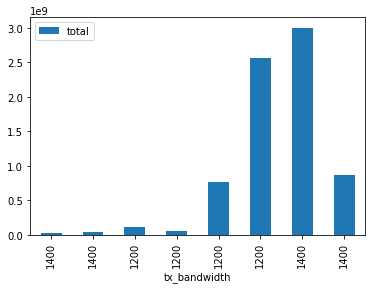

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

df3=spark.sql("select level, tx_bandwidth, sum(pkt_total) as total from LOGS group by level, tx_bandwidth")

df_3 = df3.toPandas()

df_3.plot(kind='bar', x='tx_bandwidth', y='total')

<AxesSubplot:xlabel='tx_bandwidth'>

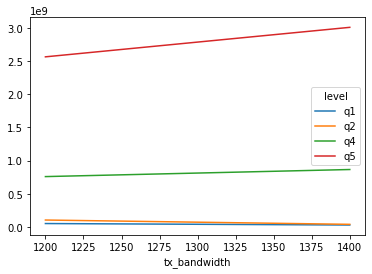

In [35]:
df4=spark.sql("select level, tx_bandwidth, sum(pkt_total) as total from LOGS group by level, tx_bandwidth")

df_4 = df4.toPandas()
df_4 = df_4.pivot(index='tx_bandwidth', columns='level', values='total')

# df_4.plot(kind='line', x='tx_bandwidth', y='total', c='level')
# df_4.plot(color=df_4.columns, figsize=(5, 3))
df_4.plot()


In [ ]:
df5=spark.sql("select level, tx_bandwidth, sum(pkt_total) as time from LOGS group by level, tx_bandwidth")

df_5 = df5.toPandas()
df_5 = df_5.pivot(index='tx_bandwidth', columns='level', values='time')

df_5.plot()

In [ ]:
df5=spark.sql("select tx_bandwidth, rx_bandwidth from LOGS group by level, tx_bandwidth")

df_5 = df5.toPandas()
df_5.plot(kind='line', x='tx_bandwidth', y='rx_bandwidth')

In [1]:
df5=spark.sql("select tx_bandwidth, avg(us_time) from LOGS group by tx_bandwidth")

df_5 = df5.toPandas()
df_5.plot(kind='bar', x='tx_bandwidth', y='us_time')

NameError: name 'spark' is not defined

In [ ]:
df6=spark.sql("select tx_bandwidth, avg(us_time) from LOGS group by tx_bandwidth")

df_6 = df5.toPandas()
df_6.plot(kind='bar', x='tx_bandwidth', y='us_time')